In [1]:
%matplotlib inline

# Práctica 2. Neural Transfer con Pytorch.


## Objetivo 

El propósito de este laboratorio es que el alumno se familiarice con el algoritmo de _Neural Style_ o _Neural Transfer_ desarrollado por Leon A. Gatys, Alexander S. Ecker y Matthias Bethge. _Neural Transfer_ permite tomar una imagen y reproducirla con un estilo artístico diferente. El algoritmo recibe como entrada 3 imágenes: una imagen de entrada, una imagen de contenido y una imagen de estilo, y cambia la entrada para parecerse a la imagen de contenido con el estilo artístico de la imagen de estilo.

La siguiente imagen muestra un ejemplo de transferencia de estilo: a la izquierda se tienen la imagen de contenido, en el centro la imagen de estilo y a la derecha la salida del método propuesto, donde se aplica la imagen de estilo a la imagen de contenido.
 
<img src="images/notebook/neuralstyle.png">


Este tutorial es una adaptación del tutorial disponible en https://pytorch.org/tutorials/advanced/neural_style_tutorial.html. 

## Referencias

- [1] Neural Transfer (básico). https://arxiv.org/abs/1508.06576
- [2] Neural Transfer (avanzado). https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
- [3] Photorealistic Neural Transfer: https://www.cs.cornell.edu/~fujun/files/style-cvpr17/style-cvpr17.html
- [4] Photorealistic Images: https://github.com/luanfujun/deep-photo-styletransfer

## Antes de empezar

Antes de empezar, asegúrese de que todos los archivos que se proporcionan con la práctica se encuentran en el mismo directorio de este Notebook.

## Parte 1. Fundamento teórico.

Aunque se recomienda echar un vistazo al artículo sobre _Neural Transfer_ [1], en esta sección se van a explicar los conceptos más importantes del algoritmo que son necesarios para el desarrollo de la práctica.

Cuando las redes neuronales convolucionales se entrenan para reconocimiento de objetos, construyen una representación de la imagen a lo largo de la jerarquía de capas convolucionales que incluye información a más bajo nivel (en las primeras capas de procesado) y a más alto nivel (a medida que se va profundizando en la arquitectura de la red). De este modo, a medida que se va progresando en la red, la imagen de entrada se transforma en representaciones que tienen menos en cuenta los valores detallados de los píxeles y más en cuenta el contenido de la imagen y su disposición en la misma. 

Por otra parte, para obtener una representación del estilo de una imagen de entrada, se usa un espacio de características diseñado originalmente para capturar la información de textura. Este espacio de características se construye sobre las respuestas de los filtros de las distintas capas de la red. Consiste en correlaciones entre las respuestas de los diferentes filtros a lo largo de la extensión espacial de los mapas de características. Al incluir las correlaciones de características de múltiples capas, se obtiene una representación multi-escala de la imagen de entrada, que captura la información de textura.

La siguiente figura muestra un ejemplo de una arquitectura de red utilizada para _Neural Transfer._ Se puede observar como a lo largo de la jerarquía de red la reconstrucción del contenido permanece prácticamente inalterada; mientras que la representación del estilo de la red tiene distintas escalas (de más detallada en las primeras capas a más global las capas más profundas) y se pierde la información espacial y del contenido de la imagen.

<img src="images/notebook/contentstyle.PNG">

Por tanto, el procedimiento de _Neural Transfer_ es capaz de separar las representaciones de contenido y estilo en una CNN. Así, se pueden manipular ambas representaciones de manera independiente. Este hecho posibilita que el procedimiento de _Neural Transfer_ sea capaz de combinar la representación del contenido de una imagen con la representación de estilo de otra, produciendo imágenes nuevas y perceptualmente significativas. 

## Parte 2. Implementación.

En primer lugar, se importan los paquetes necesarios.

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np

A continuación, se selecciona qué dispositivo usar para ejecutar la red neuronal e importar las imágenes de estilo y contenido. A partir de las funciones ``torch.cuda.is_available()`` se detecta si existe una GPU disponible.
Si existe, con ``torch.device`` se selecciona para su uso, si no se emplea la CPU. El método ``.to(device)``
se utiliza para trasladar los tensores y la red a la GPU.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Carga de imágenes

Ahora se importan las imágenes de contenido y estilo. Las imágenes originales PIL son de tipo `uint8`, de manera que tienen valores entre 0 y 255, pero a la hora de convertirlas en tensores `torch` sus valores deben estar entre 0 y 1. Asimismo, el tamaño de las imágenes de estilo y contenido debe ser el mismo. Un detalle importante es que las redes de la librería `torch` se entrenan con valores de los tensores entre 0 y 1, de manera que si se intenta entrenar la red con valores entre 0 y 255 las salidas de la red no tendrán sentido.

In [38]:
# desired size of the output image
imsize = 512 ##if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)



Ahora se crea una función que muestra una imagen convirtiéndola de nuevo a formato PIL y mostrándola usando `plt.imshow`. Se muestran las imágenes de contenido y estilo para comprobar que se han cargado correctamente.

In [39]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None, ax=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if (ax is None):
        plt.imshow(image)
        if title is not None:
            plt.title(title)
    else:
        ax.imshow(image)
        if title is not None:
            ax.set_title(title)
        
def save_image(tensor,path_to_save):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image.save(path_to_save)


### Funciones de pérdida

En el fundamento teórico hemos dicho que el principio donde radica la efectividad del procedimiento de _Neural Transfer_ es la capacidad de separar las representaciones de contenido y estilo en una CNN. Ahora bien, ¿cómo se implementa esto sobre una arquitectura de red?

El principio es simple: se definen dos distancias, una para el contenido ($D_C$) y una para el estilo ($D_S$). $D_C$ mide cómo de diferente es el contenido de dos imágenes mientras que $D_S$ mide la diferencia de estilo entre las mismas. Con esta definición, el objetivo es claro: se toma una tercera imagen (la imagen de entrada) y se transforma para minimizar la diferencia de contenido con la imagen de contenido, y la diferencia de estilo con la imagen de estilo. Seguidamente se definen las dos funciones de pérdida que se relacionan con cada una de las distancias.

#### _Content loss_

La _content loss_ es una función que representa una versión ponderada de la distancia de contenido para una capa individual, es decir, compara las salidas de una capa individual cuando la entrada a la red es: 1) la imagen de contenido $C$; y 2) la imagen de entrada $X$. El objetivo es minimizar la distancias entre estos mapas de características de manera que las representaciones de ambas sean similares, o sea, que la imagen de entrada se asemeje a la imagen de contenido.


La función toma los mapas de características $F_{XL}$ de la capa $L$ con entrada a la red $X$ y devuelve la distancia de contenido ponderada $w_{CL}.D_C^L(X,C)$ entre la imagen $X$ y la imagen de contenido $C$. Los mapas de características de la imagen de contenido ($F_{CL}$) deben ser conocidos por la función para calcular la distancia de contenido. La función se implementa a partir de un módulo `torch` con un constructor que toma las características $F_{CL}$ como entrada. La distancia $\|F_{XL} - F_{CL}\|^2$ es el error cuadrático medio entre los dos conjuntos de mapas de características y se puede calcular con la función ``nn.MSELoss``.

A la hora de implementar esta función de pérdida sobre la red, se añade este módulo directamente tras las capas convolucionales que se van a usar para calcular la distancia de contenido. De este modo, cada vez que la red recibe como entrada una imagen las funciones de pérdida de contenido se calcularán en las capas deseadas y, a causa del `auto grad` de Pytorch, se calcularán todos los gradientes. Para hacer la capa que hemos creado transparente se define un método `forward` que computa el contenido de la función de pérdida y devuelve la entrada de la capa. El valor de la pérdida se almacena como un parámetro del módulo.

In [40]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

****IMPORTANTE**: aunque el módulo se denomina ``ContentLoss``, no es una auténtica función de pérdida de Pytorch. Si se quiere definir esta pérdida como una verdadera función de pérdida de Pytorch, hay que crear una función Pytorch autograd para implementar el gradiente de manera manual en el método ``backward``.

#### _Style loss_

El módulo _style loss_ se implementa de manera similar al módulo _content loss._ Actúa como una acapa transparente en la red que computa la función de pérdida de estilo en dicha capa. Para calcularla, hay que computar la matriz de Gram $G_{XL}$. Una matriz de Gram es el resultado de multiplicar una matriz dada por su traspuesta (véase la figura). En esta aplicación la matriz dada es una versión modificada de los mapas de características $F_{XL}$ de la capa $L$, de manera que se cambian las dimensiones de $F_{XL}$ para formar la matriz $\hat{F}_{XL}$, a $K$ x $N$; donde $K$ es el número de mapas de características de la capa $L$ y $N$ la longitud de cualquier mapa de características vectorizado $F_{XL}^k$. Por ejemplo, la primera línea de $\hat{F}_{XL}$ se corresponde con el primer mapa de características vectorizado $F_{XL}^1$.

Por último, la matriz de Gram se ha de normalizar dividiendo cada elemento por el número total de elementos en la matriz. Esta normalización contrarresta el hecho de que las matrices $\hat{F}_{XL}$ con una mayor dimensión de N producen valores mayores de la matriz de Gram. Estos valores causan que las primeras capas (antes de las capas de _pooling_ de la red) tengan un impacto mayor durante el descenso por gradiente. Las características de estilo suelen estar en capas más profundas de la red de manera que este paso de normalización es crucial.

<img src="images/notebook/gram_matrix.png" style="width: 600px;">


In [41]:
def gram_matrix(input):
    a, b, c, d = input.size()  
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

El módulo _style loss_ es exactamente igual que el módulo de _content loss._ La distancia de estilo también se computa usando el error cuadrático medio entre $G_{XL}$ y $G_{SL}$.

In [42]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Modelo pre-entrenado

Hay que importar un modelo pre-entrenado de red neuronal. Se va a utilizar la misma red VGG 19 que se utiliza en la referencia [1]. 

La implementación Pytorch de VGG es un módulo dividido en dos sub-módulos `Sequential`: `features`, que contiene las capas convolucionales y de `pooling`; y `classifier`, que contiene las capas _fully connected._ Usaremos el módulo de `features` ya que se necesita la salida individual de las capas de convolución para utilizar las funciones de pérdida que se han descrito. Algunas capas, como el _Dropout_ o el _Batch Normalization,_ muestra un comportamiento distinto durante entrenamiento y evaluación, de manera que tenemos que poner la red en modo test usando `.eval()`.


In [43]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/home/cesar/Documents/Universidad/Cuarto/VisionArtificial/artificial_vision_final/venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cesar/Documents/Universidad/Cuarto/VisionArtificial/artificial_vision_final/venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Además de esto, las redes VGG se entrenan con imágenes con sus canales normalizados con los valores mean=[0.485, 0.456, 0.406] y std=[0.229, 0.224, 0.225]. Las imágenes se normalizan haciendo uso de estos valores antes de mandarlas a la red.

In [44]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Un módulo `Sequential` contiene una lista ordenada de módulos hijos. Por ejemplo, `vgg19.features` contiene una secuencia (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) alineada de capas menos profundas a más profundas (tal y como se ejecutan al pasar una imagen por la arquitectura). Hay que añadir nuestras funciones de pérdida inmediatamente después de la capa convolucional a la que van asociadas. Para hacer esto hay que crear un nuevo módulo `Sequential` que contenga las funciones de pérdida _content loss_ y _style loss_ insertadas en el orden correcto.

In [45]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8', 'conv_9', 'conv_10']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

### Descenso por Gradiente

Como sugiere Leon Gatys, el autor del algoritmo, en este [link](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq), se utiliza el algoritmo L-BFGS para el descenso por gradiente en la red. Al contrario que para entrenar una red, en la que el objetivo es la salida de la misma (ya sea una segmentación, una etiqueta, etc.) en nuestro caso se quiere entrenar la imagen de entrada para minimizar las pérdidas _content loss_ y _style loss._ Se crea un optimizador de Pytorch con el algoritmo L-BFGS `optim.LBFGS` y se pasa la imagen como un tensor para optimizarla.

In [46]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

Finalmente, se define una función que ejecuta la red neuronal. Para cada iteración, se introduce la nueva imagen (modificada desde la imagen inicial) a la entrada y se computan los nuevos valores de las pérdidas. El método `backward` ejecuta de manera dinámica los gradientes para cada función de pérdida. El optimizador requiere una función de _closure_ que re-evalúa el modelo y devuelve la pérdida.

Todavía hay una restricción final que enfrentar. La red podría intentar optimizar la entrada con valores externos al rango 0-1. Podemos enfrentarnos a esto restringiendo los valores de la entrada al rango 0-1 cada vez que se ejecuta la red sobre la imagen.


In [47]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,print_step=50,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, style_layers=style_layers_default)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % print_step == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Parte 3. Experimentos.

### 1. Monitorización del aprendizaje

Analice cómo se produce el aprendizaje de la red en los primeros _epochs_ paso a paso, cuando se introduce como imagen de entrada un ruido blanco.
- Primero, iguale los pesos del contenido y el estilo para la función `run_style_transfer`. ¿Qué resulta más sencillo en este caso, aprender el estilo o el contenido de la imagen? ¿Por qué?
- Segundo, utilice los pesos por defecto de la función. Analice el resultado en este caso.

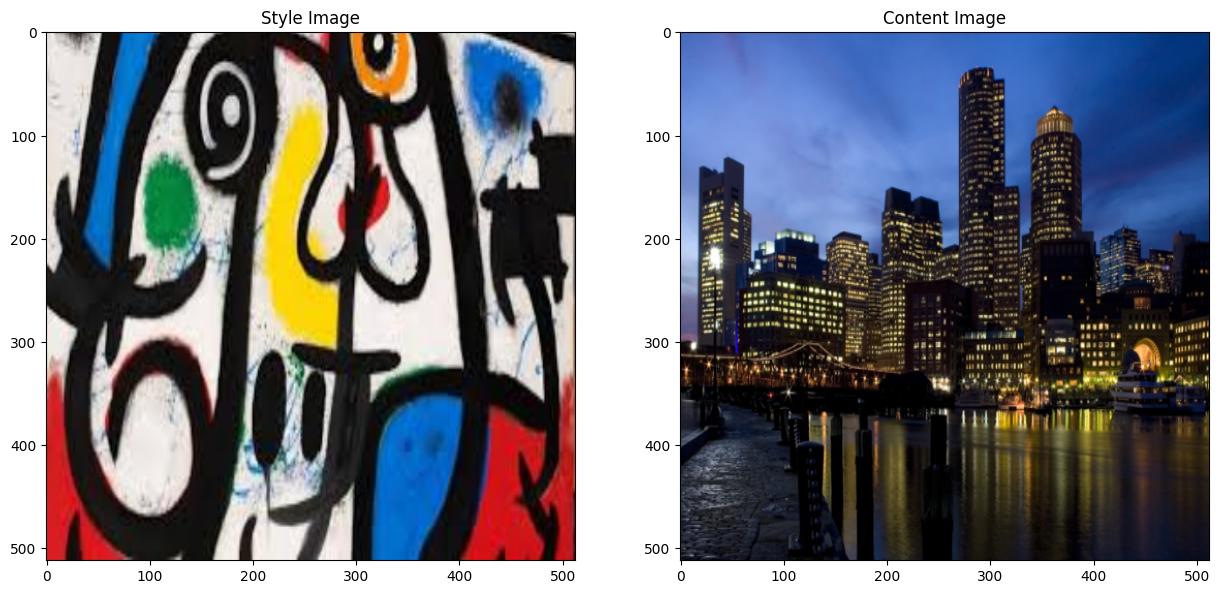

In [48]:
# selección de imágenes
content_img = image_loader("images/photorealistic/style/tar3.png")
style_img = image_loader("images/joan_miro.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
ax0, ax1 = axes.flatten()
imshow(style_img, title='Style Image',ax=ax0)
imshow(content_img, title='Content Image',ax=ax1)

In [ ]:
result_dir='results-reverse'
# Generate a folder to save results
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
exp_dir=os.path.join(result_dir,'exp1')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

# White noise
input_img = torch.randn(content_img.data.size(), device=device)
step=100

imshow(input_img,title='Noisy Image')
save_image(input_img,os.path.join(exp_dir,'original.png'))

for j in range(10):
    input_img = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img, num_steps=step, print_step=step,
                                content_weight=1, style_weight=1e3)
    imshow(input_img,title='Step '+str(j))
    save_image(input_img,os.path.join(exp_dir,'step'+str(j*step)+'.png'))

Building the style transfer model..


/tmp/ipykernel_1426461/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1426461/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [100]:
Style Loss : 6.680463 Content Loss: 13.676063

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 4.262183 Content Loss: 8.704876

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 3.535397 Content Loss: 7.098794

Building the style transfer model..
Optimizing..


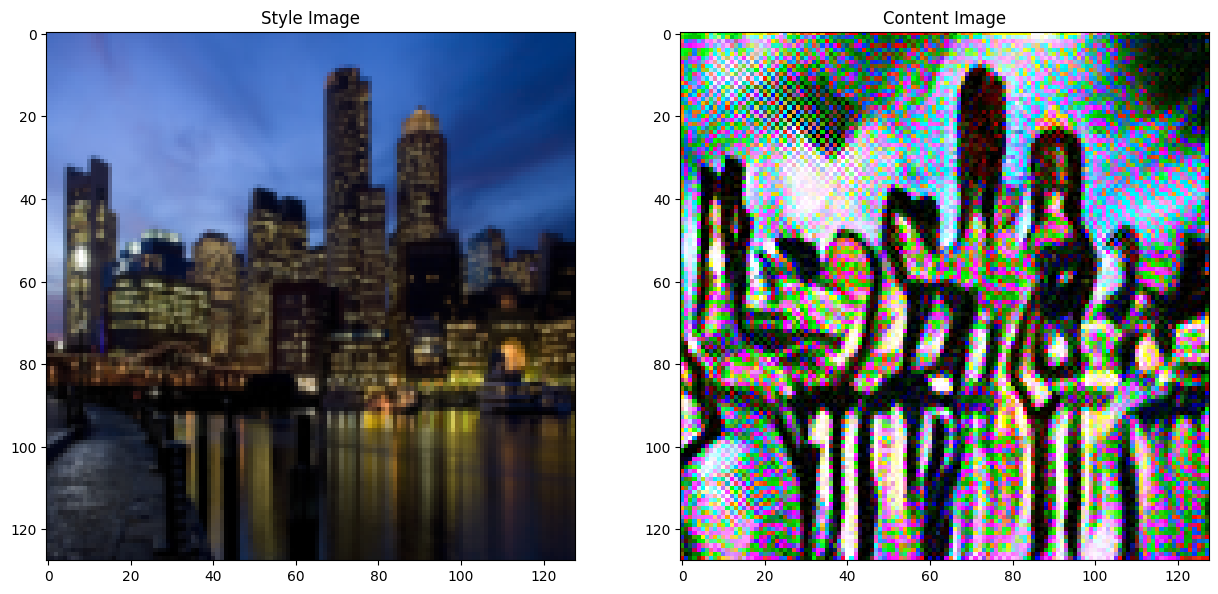

In [24]:
# selección de imágenes
style_img = image_loader("images/photorealistic/style/tar3.png")
content_img = image_loader("results-reverse/exp1/intermedio.png")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,15))
ax0, ax1 = axes.flatten()
imshow(style_img, title='Style Image',ax=ax0)
imshow(content_img, title='Content Image',ax=ax1)

In [37]:
iteration=iteration
print(style_layers_default)


['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6', 'conv_7', 'conv_8', 'conv_9', 'conv_10']


Building the style transfer model..


/tmp/ipykernel_1426461/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1426461/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [100]:
Style Loss : 0.082749 Content Loss: 0.003763

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.076025 Content Loss: 0.003553

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.070835 Content Loss: 0.003053

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.066182 Content Loss: 0.002232

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.061234 Content Loss: 0.002091

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.057745 Content Loss: 0.001799

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.054569 Content Loss: 0.001521

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.051434 Content Loss: 0.002372

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.048226 Content Loss: 0.001260

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 0.046423 

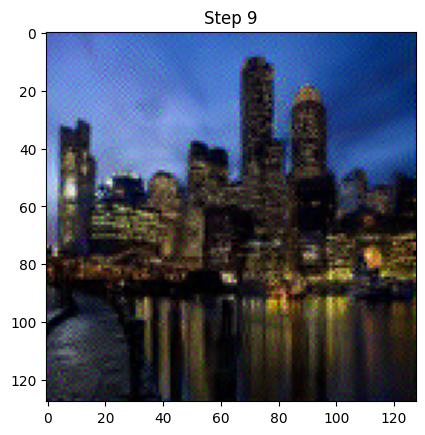

In [36]:
result_dir=f'it-0{iteration}'
iteration +=1

content = 1
style = 1e3
rounds = 10
# Generate a folder to save results
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
exp_dir=os.path.join(result_dir,'exp1')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

# White noise
input_img = torch.randn(content_img.data.size(), device=device)
step=100

with open(os.path.join(exp_dir, "params"), "w") as fd:
    fd.write(result_dir)
    fd.write("\n")
    fd.write(f"conv_layers: {len(style_layers_default)}\n")
    fd.write(f"content_weight: {content}\n")
    fd.write(f"style_weight: {style}\n")
    fd.write(f"rounds: {rounds}\n")
    fd.write("input_img: content\n")

imshow(input_img,title='Noisy Image')
save_image(input_img,os.path.join(exp_dir,'original.png'))

for j in range(rounds):
    input_img = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, content_img, num_steps=step, print_step=step,
                                content_weight=content, style_weight=style)
    imshow(input_img,title='Step '+str(j))
    save_image(input_img,os.path.join(exp_dir,'step'+str(j*step)+'.png'))

### 2. Imagen de entrada vs ruido blanco.

Ejecute el algoritmo de _Neural Transfer_ a partir de la imagen de contenido (durante 300 epochs) frente a la imagen con ruido blanco (900 epochs, el entrenamiento es más lento). Analice la salida del mismo a bajo nivel. 
- ¿Qué ocurre cuando la imagen de entrada es ruido blanco? ¿Se le ocurre alguna manera de resolver este efecto? En la celda de abajo hay un pequeño ejemplo.

- Ahora ejecute el algoritmo con la imagen de contenido durante un número mayor de epochs (1500, por ejemplo). ¿Qué ha ocurrido a bajo nivel? ¿Por qué?

Building the style transfer model..
Optimizing..


/tmp/ipykernel_1426461/1744401072.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipykernel_1426461/1744401072.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [100]:
Style Loss : 81.850525 Content Loss: 59.157581

run [200]:
Style Loss : 30.556198 Content Loss: 54.006607

run [300]:
Style Loss : 18.962584 Content Loss: 49.221928

Building the style transfer model..
Optimizing..
run [100]:
Style Loss : 112.758270 Content Loss: 85.019875

run [200]:
Style Loss : 37.988518 Content Loss: 71.215042

run [300]:
Style Loss : 23.351509 Content Loss: 61.721371

run [400]:
Style Loss : 14.963860 Content Loss: 55.296215

run [500]:
Style Loss : 12.062366 Content Loss: 50.598698

run [600]:
Style Loss : 10.495389 Content Loss: 47.544659

run [700]:
Style Loss : 9.452905 Content Loss: 45.305099

run [800]:
Style Loss : 8.867439 Content Loss: 43.823353

run [900]:
Style Loss : 9.049792 Content Loss: 42.807224



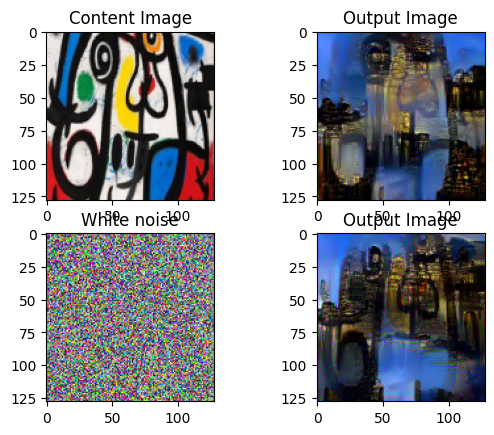

In [14]:
# Generate a folder to save results
exp_dir=os.path.join(result_dir,'exp2')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

# Content image
input_img = content_img.clone()

# add the original input image to the figure:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax1, ax2, ax3, ax4 = axes.flatten()
imshow(input_img,title='Content Image',ax=ax1)
save_image(input_img,os.path.join(exp_dir,'input_content.png'))


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=300,print_step=100)

imshow(output, title='Output Image',ax=ax2)
save_image(output,os.path.join(exp_dir,'output_content_300.png'))


# White noise
input_img = torch.randn(content_img.data.size(), device=device)
imshow(input_img,title='White noise',ax=ax3)
# Gaussian smooth
#from scipy.ndimage import gaussian_filter
#input_img=gaussian_filter(input_img.squeeze().permute(1,2,0).cpu().numpy(), 3.0)
#input_img=input_img-input_img.min()
#input_img=input_img/input_img.max()
#input_img=torch.from_numpy(np.ascontiguousarray(np.transpose(input_img,(2,0,1)))).unsqueeze(0).to(device,torch.float)
save_image(input_img,os.path.join(exp_dir,'input_noise.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output,title='Output Image',ax=ax4)
save_image(output,os.path.join(exp_dir,'output_noise.png'))

### 3. Características de las imágenes de entrada

En este apartado se van a realizar algunas pruebas con otros pares de imágenes para visualizar el funcionamiento del algoritmo en distintos casos. 

- Cargue los pares de imágenes de contenido `turtle.png` y `wave.png`; y `tuebingen.jpg` y `pillars_by_creation.jpg` y ejecute el algoritmo de _Neural Transfer_ sobre las mismas. Observe las diferencias.

In [ ]:
exp_dir=os.path.join(result_dir,'exp3')
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)

style_img = image_loader("images/wave.jpg")
content_img = image_loader("images/turtle.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


    
imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'original1.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'output1.png'))

style_img = image_loader("images/pillars_by_creation.jpg")
content_img = image_loader("images/tuebingen.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


    
imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'original2.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'output2.png'))

- Intercambie las imágenes de contenido y estilo y ejecute de nuevo la red. ¿Qué características deben tener las imágenes de contenido y las imágenes de estilo de la red?

In [ ]:
style_img = image_loader("images/turtle.jpg")
content_img = image_loader("images/wave.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'changed1.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'output_changed1.png'))

style_img = image_loader("images/tuebingen.jpg")
content_img = image_loader("images/pillars_by_creation.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'changed2.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'output_changed2.png'))

- Haga pruebas con las dos imágenes de contenido y las dos imágenes de estilo y analice los resultados.

In [ ]:
style_img = image_loader("images/tuebingen.jpg")
content_img = image_loader("images/turtle.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'content.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'content_output.png'))

style_img = image_loader("images/pillars_by_creation.jpg")
content_img = image_loader("images/wave.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'style.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'style_output.png'))

- Aplique un estilo diferente a alguna de las imágenes de contenido con las que se cuenta. Compárelo con el estilo que se ha aplicado anteriormente y comente las diferencias.

In [ ]:
style_img = image_loader("images/picasso.jpg")
content_img = image_loader("images/turtle.jpg")
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

imshow(input_img,title='Content Image')
save_image(input_img,os.path.join(exp_dir,'turtle_picasso.png'))

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=900,print_step=100)

imshow(output, title='Output Image')
save_image(output,os.path.join(exp_dir,'turtle_picasso_output.png'))


### 4. Evaluación del trabajo autónomo del alumno.

#### Criterios de evaluación

De esta práctica (si elegida) surge la segunda evaluación para la asignatura. Una vez comprendidos los fundamentos del algoritmo de transferencia de estilo, puede realizar los experimentos que considere oportunos. Estos experimentos pueden ir dirigidos a:

- Profundizar en la arquitectura (observar cómo dependen las representaciones de estilo y contenido de la red del punto de la arquitectura de donde se extraigan).
- Analizar los resultados y proporcionar estrategias de mejora.
- Extraer características más generales, de un artista o un movimiento artístico.


#### Entregables

- Presentación (17/05/2020). Este día cada grupo de alumnos tendrá un turno de 10 minutos de preguntas (máximo 5 minutos de presentación) sobre el apartado de trabajo autónomo con ayuda de un máximo de 3 transparencias.
- Informe + Código. Los alumnos entregarán un breve informe (2 caras para la descripción, 1 cara de referencias y figuras si fuese necesaria) donde describirán los aspectos más importantes de la solución propuesta. El objetivo es que el alumno describa los análisis y extensiones que ha planteado al modelo y justifique su objetivo y utilidad de manera breve. Asimismo, se proporcionará el código utilizado para los experimentos (bien sobre este mismo Notebook, en formato `.ipynb` o bien en código Python, en formato `.py`). 

La fecha límite de entrega del fichero de resultados y el informe es el domingo 14 de Mayo a las 23:59.

#### Sugerencias

A continuación se proporcionan algunas sugerencias para que el alumno trabaje de manera autónoma, a título informativo. Si lo desea, puede centrarse en implementar una o varias de ellas.

- Modifique la representación del contenido que realiza el algoritmo (en lugar de usar conv_4, use otras capas) y analice el resultado.

- Pondere las contribuciones de las capas en la transferencia de estilo de la red y observe cómo se modifica la salida de la misma. Justifique los resultados.

- Se han proporcionado varias obras de distintos autores y estilos: Van Gogh (postimpresionismo), Kandinsky (arte abstracto), Picasso (cubismo) y Munch (expresionismo). Modifique el algoritmo de transferencia de estilo para intentar extraer características generales de cada autor y estilo a través de sus obras (priorice la información a alto nivel, bajo nivel, etc.). Compare con las salidas individuales de aplicar el algoritmo a obras concretas. Vea el efecto al incluir otras obras de los artistas o del movimiento pictórico con características diferentes.

- El algoritmo de _Neural Transfer_ no solo se puede usar bajo un punto de vista artístico. También se puede utilizar para modificar características de imágenes reales (iluminación, color, etc.) [2]. Se proporciona una base de datos, de [4], para transferencia neuronal sobre imágenes reales. Realice experimentos sobre esta base de datos, analice la calidad del algoritmo según el tipo de imagen, proporcione mejoras al algoritmo, etc. En el artículo [3] hay algunas estrategias para aumentar el realismo de las imágenes generadas.
